In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data, coupling_flow

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)


cuda:2


# ncond = 0

In [31]:
def collect_all_data_nocond(key):
    
    transported_results = {"left":[0,0], # x, y
                           "right":[0,0], # x, y
                           "base_transfer":[0,0],
                           "f4f":[0,0],
                           "unidir_start":[0,0],
                           "unidir_end":[0,0],
                           "L1_start":[0,0],
                           "L1_end":[0,0],
                                }
    
    eval_dict_root = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/eval_data.h5")
    
    transported_results["left"] = [results_root["left_data_x"], results_root["left_data_y"]]
    transported_results["right"] = [results_root["right_data_x"], results_root["right_data_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["left_to_right_x"], results_root["left_to_right_y"]]
    
    # unidir
    eval_dict_unidir = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/eval_data.h5")
    transported_results["unidir_start"] = [results_unidir["left_data_x"], results_unidir["left_data_y"]]
    transported_results["unidir_end"] = [results_unidir["left_to_right_x"], results_unidir["left_to_right_y"]]

    # l1
    eval_dict_l1 = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_l1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/eval_data.h5")
    transported_results["L1_start"] = [results_l1["left_data_x"], results_l1["left_data_y"]]
    transported_results["L1_end"] = [results_l1["left_to_right_x"], results_l1["left_to_right_y"]]
    
    # l1
    eval_dict_identinit = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    transported_results["II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
    
    
    return transported_results


def plot_data_nocond(results_dir, size = 4):
    

    fig, ax = plt.subplots(1, 7, figsize = (7*size, size))

    ax[0].scatter(results_dir["left"][0], results_dir["left"][1], s = 1)
    ax[0].set_title("left data")

    ax[1].scatter(results_dir["right"][0], results_dir["right"][1], s = 1)
    ax[1].set_title("target data")
    
    ax[2].scatter(results_dir["base_transfer"][0], results_dir["base_transfer"][1], s = 1)
    ax[2].set_title("base transfer")
    
    ax[3].scatter(results_dir["f4f"][0], results_dir["f4f"][1], s = 1)
    ax[3].set_title("flow for flow")
    
    ax[4].scatter(results_dir["unidir_end"][0], results_dir["unidir_end"][1], s = 1)
    ax[4].set_title("unidirectional")
    
    ax[5].scatter(results_dir["L1_end"][0], results_dir["L1_end"][1], s = 1)
    ax[5].set_title("f4f + L1")
    
    ax[6].scatter(results_dir["II_end"][0], results_dir["II_end"][1], s = 1)
    ax[6].set_title("f4f + ident init")
        
     
    fig.show()

    
def calculate_distance_xy(results_dir, key_1, key_2):
    # x distance
    del_xes = results_dir[key_1][0] - results_dir[key_2][0]
    # y distance
    del_yes = results_dir[key_1][1] - results_dir[key_2][1]
    
    dists = np.sqrt(del_xes**2 + del_yes**2)
    return dists


def calculate_distance_and_plot(results_dir, bins = 20, n_round = 5):
    
    distances_dict = {}
    
     # base_transfer
    distances_dict["baseline"] = calculate_distance_xy(results_dir, "left", "right")
    # base_transfer
    distances_dict["base_transfer"] = calculate_distance_xy(results_dir, "left", "base_transfer")
    # f4f
    distances_dict["f4f"] = calculate_distance_xy(results_dir, "left", "f4f")
    # unidir
    distances_dict["unidir"] = calculate_distance_xy(results_dir, "unidir_start", "unidir_end")
    # L1
    distances_dict["L1"] = calculate_distance_xy(results_dir, "L1_start", "L1_end")
    # II
    distances_dict["II"] = calculate_distance_xy(results_dir, "II_start", "II_end")

    fig = plt.figure(figsize = (6, 6))
    for i, k in enumerate(distances_dict.keys()):
        # calculate distance traveled with respect to input
        plt.hist(distances_dict[k], bins = bins, histtype = "step", label = k)
        
        loc_mean = np.round(np.mean(distances_dict[k]), n_round)
        loc_std = np.round(np.std(distances_dict[k]), n_round)
        print("Method", k, ":", loc_mean, "+/-", loc_std)
    plt.legend()

    plt.xlabel("Distance traveled")
    plt.ylabel("Counts")

    plt.show()

    

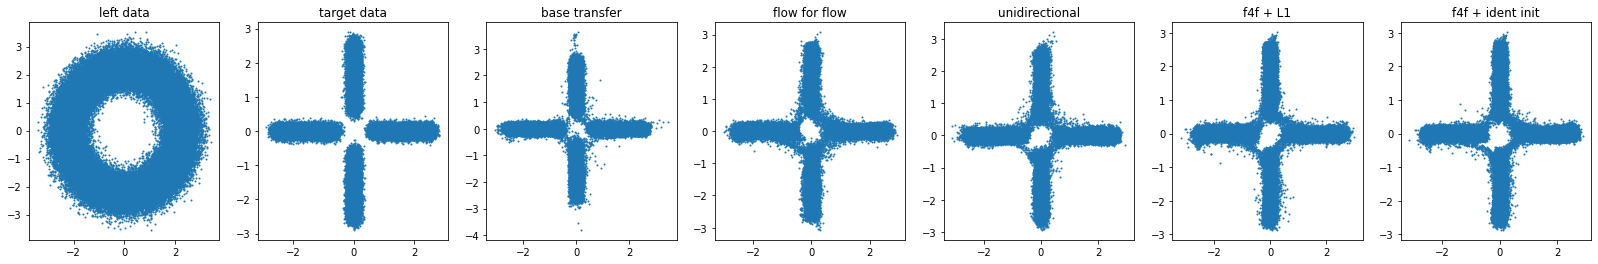

In [32]:

# get the data
ring_dir = collect_all_data_nocond("ring_star_nocond")

# plot
plot_data_nocond(ring_dir)

Method, baseline : 2.63153 +/- 1.13169
Method, base_transfer : 1.94899 +/- 0.63108
Method, f4f : 1.1199 +/- 0.59116
Method, unidir : 1.21173 +/- 0.49632
Method, L1 : 1.08298 +/- 0.55763
Method, II : 1.07559 +/- 0.54141


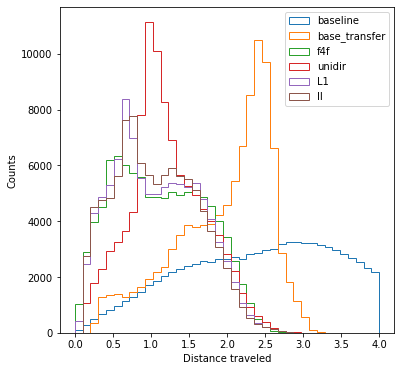

In [33]:
# calculate distances
    
calculate_distance_and_plot(ring_dir, bins = np.linspace(0, 4, 40))

# ncond = 1

In [5]:

def collect_all_data_cond(key):
    
    transported_results = {"left":[0,0], # x, y
                           "right":[0,0], # x, y
                           "base transfer":[0,0],
                           "left -> right":[0,0],
                           "f4f":[0,0],
                           "f4f + L1":[0,0],
                                }
    
    # base_transfer and f4f
    eval_dict_root = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/eval_data.h5")
    
    transported_results["left"] = [results_root["left_data_x"], results_root["left_data_y"]]
    transported_results["right"] = [results_root["right_data_x"], results_root["right_data_y"]]

    transported_results["base transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["left_to_right_x"], results_root["left_to_right_y"]]
    
    # unidir
    eval_dict_unidir = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/eval_data.h5")
    transported_results["left -> right"] = [results_unidir["right_to_left_x"], results_unidir["right_to_left_y"]]
    
    # l1
    eval_dict_l1 = f"/global/home/users/rrmastandrea/flows4flows/writeup/{key}_l1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/eval_data.h5")
    transported_results["f4f + L1"] = [results_l1["left_to_right_x"], results_l1["left_to_right_y"]]
    
    return transported_results
    

In [6]:
eval_dict = "/global/home/users/rrmastandrea/flows4flows/writeup/checkerboard_to_circles_cond/"

f4f_df_cond = pd.read_hdf(f"{eval_dict}/flow4flow_plots/eval_data_conditional.h5", "f4f_30_00")

FileNotFoundError: File /global/home/users/rrmastandrea/flows4flows/writeup/checkerboard_to_circles_cond//flow4flow_plots/eval_data_conditional.h5 does not exist

In [ ]:
# make some plots

fig, ax = plt.subplots(1, 4, figsize = (16, 4))

ax[0].scatter(f4f_df_cond["input_x"], f4f_df_cond["input_y"], s = 1)
ax[0].set_title("left data")

ax[1].scatter(f4f_df_cond["transformed_x"], f4f_df_cond["transformed_y"], s = 1)
ax[1].set_title("left to right data")

ax[2].scatter(f4f_df_cond["base_transfer_x"], f4f_df_cond["base_transfer_y"], s = 1)
ax[2].set_title("base transfer data")

#ax[3].scatter(f4f_df_cond["right_data_x"], f4f_df_cond["right_data_y"], s = 1)
#ax[3].set_title("right data")

fig.show()



In [ ]:
distances_f4f = calculate_distance_xy(f4f_df_cond, "input", "transformed")

distances_base_transfer = calculate_distance_xy(f4f_df_cond, "input", "base_transfer")



fig, ax = plt.subplots(1, 1, figsize = (4, 4))
bins = np.linspace(0, 4, 40)

ax.hist(distances_f4f, bins = bins, histtype = "step", label = "f4f")
ax.hist(distances_base_transfer, bins = bins, histtype = "step", label = "base transfer")

ax.legend()

fig.show()

# Science

In [ ]:
# Get training data

train_sim_data = torch.from_numpy(np.load("LHCO_data/train_sim_data.npy")).to(torch.float32)
val_sim_data = torch.from_numpy(np.load("LHCO_data/val_sim_data.npy")).to(torch.float32)
train_dat_data = torch.from_numpy(np.load("LHCO_data/train_dat_data.npy")).to(torch.float32)
val_dat_data = torch.from_numpy(np.load("LHCO_data/val_dat_data.npy")).to(torch.float32)

train_sim_cont = torch.from_numpy(np.load("LHCO_data/train_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
val_sim_cont = torch.from_numpy(np.load("LHCO_data/val_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
train_dat_cont = torch.from_numpy(np.load("LHCO_data/train_dat_cont.npy").reshape(-1, 1)).to(torch.float32)
val_dat_cont = torch.from_numpy(np.load("LHCO_data/val_dat_cont.npy").reshape(-1, 1)).to(torch.float32)

In [ ]:
# Plot training data

bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 6, figsize = (16, 4))

for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].legend()
    
# context
ax[5].hist(val_sim_cont.numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
ax[5].hist(val_dat_cont.numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
ax[5].legend()
    
plt.show()

In [ ]:
# load in the flow



flow_dir = "/global/home/users/rrmastandrea/flows4flows/writeup/science/"

with open(f"{flow_dir}/science.yaml") as f:
    defaults = yaml.safe_load(f)
    
    
base_flow_left_path = f"{flow_dir}/base_left/epoch_31.pt"
base_flow_right_path = f"{flow_dir}/base_right/epoch_31.pt"


f4f_unidir_path = f"{flow_dir}/f4f_inv/epoch_31.pt"
f4f_bidir_path = "/global/home/users/rrmastandrea/flows4flows/writeup/science_alternate/f4f/epoch_31.pt"

In [ ]:
# load in the flow


base_flow_left = BaseFlow(spline_inn(defaults["general"]["data_dim"],
                                    nodes = defaults["base_dist"]["left"]["nnodes"],
                                 num_blocks =   defaults["base_dist"]["left"]["nblocks"],
                                    num_stack = defaults["base_dist"]["left"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults["base_dist"]["left"]["nbins"],
                                    context_features=defaults["general"]["ncond"]
                                    ),
                         StandardNormal([defaults["general"]["data_dim"]])
                         )
base_flow_left.load_state_dict(torch.load(base_flow_left_path, map_location=device))
set_trainable(base_flow_left, False)

base_flow_right = BaseFlow(spline_inn(defaults["general"]["data_dim"],
                                    nodes = defaults["base_dist"]["right"]["nnodes"],
                                 num_blocks =   defaults["base_dist"]["right"]["nblocks"],
                                    num_stack = defaults["base_dist"]["right"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults["base_dist"]["right"]["nbins"],
                                    context_features=defaults["general"]["ncond"]
                                    ),
                         StandardNormal([defaults["general"]["data_dim"]])
                         )
base_flow_right.load_state_dict(torch.load(base_flow_right_path, map_location=device)) 
set_trainable(base_flow_right, False)
            
    
f4f_unidir = get_flow4flow('discretebasecondition',
                           spline_inn(defaults["general"]["data_dim"],
                                      nodes=defaults["top_transformer"]["nnodes"],
                                      num_blocks=defaults["top_transformer"]["nblocks"],
                                      num_stack=defaults["top_transformer"]["nstack"],
                                      tail_bound=4.0,
                                      activation=get_activation(defaults["top_transformer"]["activation"]),
                                      num_bins=defaults["top_transformer"]["nbins"],
                                      context_features=defaults["general"]["ncond"],
                                      flow_for_flow=True
                                      ),
                           distribution_right=base_flow_right,
                           distribution_left=base_flow_left)
f4f_unidir.load_state_dict(torch.load(f4f_unidir_path, map_location=device)) 
set_trainable(f4f_unidir, False)   



f4f_bidir = get_flow4flow('discretebasecondition',
                           spline_inn(defaults["general"]["data_dim"],
                                      nodes=defaults["top_transformer"]["nnodes"],
                                      num_blocks=defaults["top_transformer"]["nblocks"],
                                      num_stack=defaults["top_transformer"]["nstack"],
                                      tail_bound=4.0,
                                      activation=get_activation(defaults["top_transformer"]["activation"]),
                                      num_bins=defaults["top_transformer"]["nbins"],
                                      context_features=defaults["general"]["ncond"],
                                      flow_for_flow=True
                                      ),
                           distribution_right=base_flow_right,
                           distribution_left=base_flow_left)
f4f_bidir.load_state_dict(torch.load(f4f_bidir_path, map_location=device)) 
set_trainable(f4f_bidir, False)   


In [ ]:
# check base densities

n_transform = 55753 # size of dat (smaller) dataset

noise = torch.normal(0, 1, size=(n_transform, 5))
bd_samples_sim, _ = base_flow_left._transform.inverse(noise, val_sim_cont[:n_transform])
bd_samples_dat, _ = base_flow_right._transform.inverse(noise, val_dat_cont[:n_transform])


bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(bd_samples_sim[:,i].numpy(), bins = bins, label = "bd", histtype = "bar", density = True, color = "red", alpha = 0.5)

    ax[i].legend(loc = "lower right")
    
plt.show()




fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "blue")
    ax[i].hist(bd_samples_dat[:,i].numpy(), bins = bins, label = "bd", histtype = "bar", density = True, color = "blue", alpha = 0.5)

    ax[i].legend(loc = "lower right")
    
plt.show()




In [ ]:
ndat = 55753


# Transform the data
transformed_unidir, _ = f4f_unidir.batch_transform(val_sim_data[:ndat], val_sim_cont[:ndat], val_sim_cont[:ndat], batch_size=1000)
transformed_bidir, _ = f4f_bidir.batch_transform(val_sim_data[:ndat], val_sim_cont[:ndat], val_sim_cont[:ndat], batch_size=1000)

# Get the transformation that results from going via the base distributions
left_bd_enc = f4f_unidir.base_flow_left.transform_to_noise(val_sim_data[:ndat], val_sim_cont[:ndat])
right_bd_dec, _ = f4f_unidir.base_flow_right._transform.inverse(left_bd_enc, val_sim_cont[:ndat].view(-1, 1))



transported_results_lhc = {"input": val_sim_data[:ndat].numpy(),
                           "target":val_dat_data[:ndat].numpy(),
                           "base_transfer":right_bd_dec.numpy(),
                           "unidir":transformed_unidir.numpy(),
                           "bidir":transformed_bidir.numpy(),

                                }

labels_lhc = transported_results_lhc.keys()

bins = np.linspace(-3.5, 3.5, 40)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(transported_results_lhc["input"][:,i], bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(transported_results_lhc["target"][:,i], bins = bins, label = "dat", histtype = "step", density = True, color = "blue")

    ax[i].hist(transported_results_lhc["unidir"][:,i], bins = bins, label = "trans sim uni", histtype = "step", density = True, color = "purple")
    ax[i].hist(transported_results_lhc["bidir"][:,i], bins = bins, label = "trans sim bi", histtype = "step", density = True, color = "black")

    ax[i].hist(transported_results_lhc["base_transfer"][:,i], bins = bins, label = "double base", histtype = "bar", density = True, color = "purple", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()



In [ ]:
def calculate_distance_lhco(results_dir, key_1, key_2, index = None):
    
    if index is not None:
        dists = np.linalg.norm(results_dir[key_1][:,index].reshape(-1, 1) - results_dir[key_2][:,index].reshape(-1, 1), axis = 1)
        
    else:
        dists = np.linalg.norm(results_dir[key_1] - results_dir[key_2], axis = 1)
    return dists

In [ ]:
# total distance

bins = np.linspace(0, 6, 60)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
for i, k in enumerate(labels_lhc):
    # calculate distance traveled with respect to input
    loc_distances = calculate_distance_lhco(transported_results_lhc, "input", k)
    if k != "input":
        ax.hist(loc_distances, bins = bins, histtype = "step", label = k)

fig.legend()

ax.set_xlabel("Distance traveled")
ax.set_ylabel("Counts")

fig.show()




# feature distances

bins = np.linspace(0, 6, 60)

fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for j in range(5):

    for i, k in enumerate(labels_lhc):
        # calculate distance traveled with respect to input
        loc_distances = calculate_distance_lhco(transported_results_lhc, "input", k, j)
        if k != "input":
            ax[j].hist(loc_distances, bins = bins, histtype = "step", label = k)
            ax[j].set_xlabel(f"Feature {j}")

ax[0].legend()


ax[0].set_ylabel("Counts")

fig.show()